In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [3]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

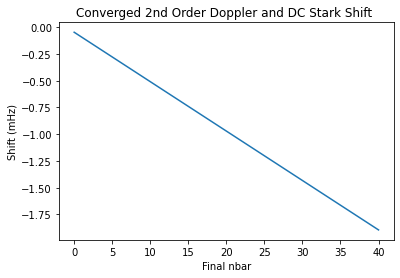

In [8]:
pts = 5
nbarfs = np.linspace(0, 40, pts)
Ncut = 1201
nbar0 = 0.0
shifts = -expEHeat(nbar0, nbarfs, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
plt.plot(nbarfs,shifts*nu0*1.0e3, label="Ncut=1201")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [5]:
def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [18]:
Ncut = 601
pts = 5
nbarfs = np.linspace(0, 40, pts)
psi0 = psi(0.0, 1.0)
Delta = 18.303*2.0*np.pi*1.0e-3 #hz
Omega0 = 20.0*2.0*np.pi #hz
nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = 3.0*np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)


0.0
6.154456162935089e-08
10.0
0.00024727409123724195
20.0
0.0004731227947227715
30.0
0.0006826801253466468
40.0
0.0008799923445351921


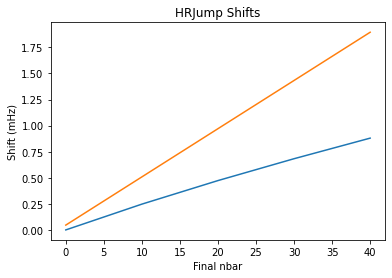

In [19]:
plt.plot(nbarfs,shifts1*1e3, label="HRSJump")
plt.plot(nbarfs,-shifts*nu0*1.0e3, label="Doppler and Stark Shifts")

plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("HRJump Shifts")
plt.show()

In [10]:
#Omega0 = 20*2*pi
#T = 50 ms
#Delta = 0.23 = 36.606*2*pi*1e-3 
array([4.92336351e-07, 4.94936388e-04, 9.46653168e-04, 1.36578738e-03,
       1.76043134e-03])

array([4.92336351e-07, 4.94936388e-04, 9.46653168e-04, 1.36578738e-03,
       1.76043134e-03])

In [14]:
#Omega0 = 20*2*pi
#T = 100 ms
#Delta = 0.23 = 36.606*2*pi*1e-3 
array([2.46176291e-07, 2.47737773e-04, 4.74308534e-04, 6.84935873e-04,
       8.83608392e-04])

array([2.46176291e-07, 2.47737773e-04, 4.74308534e-04, 6.84935873e-04,
       8.83608392e-04])

In [17]:
#Omega0 = 40*2*pi
#T = 100 ms
#Delta = 0.23 = 36.606*2*pi*1e-3 
array([3.07723167e-08, 1.23836856e-04, 2.37293796e-04, 3.42866911e-04,
       4.42536349e-04])

array([3.07723167e-08, 1.23836856e-04, 2.37293796e-04, 3.42866911e-04,
       4.42536349e-04])

In [21]:
#Omega0 = 20*2*pi
#T = 50 ms
#Delta = 18.303*2*pi*1e-3 
array([6.15445616e-08, 2.47274091e-04, 4.73122795e-04, 6.82680125e-04,
       8.79992345e-04])

NameError: name 'array' is not defined

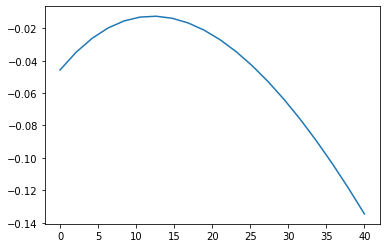

In [45]:
plt.plot(nbarfs,(shifts1+shifts*nu0)*1.0e3, label="Ncut=1201")


Now for the Modified Hyper Ramsey scheme:

In [5]:
def MHRSthermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, phi0, phi1)@psi0
    return result

In [6]:
def HRAThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    #thermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delPrime, np.pi/2.0, -np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delPrime, 0.0, 0.0, eta, nbarf, Ncut)
    return state4

def HRAThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delPrime, -np.pi/2.0, np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delPrime, 0.0, 0.0, eta, nbarf, Ncut)
    return state4
    
def HRBThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delPrime, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -np.pi/2.0, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delPrime, 0.0, -np.pi/2.0, eta, nbarf, Ncut)
    return state4

def HRBThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delPrime, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delPrime, np.pi, -3.0*np.pi/2.0, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delPrime, 0.0, np.pi/2.0, eta, nbarf, Ncut)
    return state4

In [7]:
def MHRThermES1(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRAThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRBThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut))
def MHRThermES2(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRBThermp(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRAThermn(deld, psi0, t, T, Delta, Omega0, eta, nbar0, nbarf, Ncut))

In [68]:
#pts = 15
#Ncut = 601
#psi0 = psi(0.0, 1.0)
#Delta = 0.23 #*2.0*np.pi #hz
#Omega0 = 20.0*2.0*np.pi #hz
#nbar0 = 0.0 
t = np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05
shifts2 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0
for ii in range(pts):
    #print(ii)
    print(nbarfs[ii])
    shifts2[ii] = sp.optimize.root_scalar(MHRThermES1, args=(psi0, t, T, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts2[ii])
    x0 = shifts2[ii] - guessTol
    x1 = shifts2[ii] + guessTol
    #print(x0,x1)

0.0
1.8893697560781546e-15
2.1052631578947367
0.002089521844131548
4.2105263157894735
0.006847599364784144
6.315789473684211
0.014214978325503815
8.421052631578947
0.024131702204758777
10.526315789473683
0.036537251225199366
12.631578947368421
0.05137067126176127
14.736842105263158
0.06857069313975887
16.842105263157894
0.08807584268204656
18.94736842105263
0.10982454027839651
21.052631578947366
0.13375518164945277
23.157894736842103
0.1598061745611992
25.263157894736842
0.1879158845882709
27.36842105263158
0.21802243343408578
29.473684210526315
0.2500633100179493
31.57894736842105
0.2839747950926956
33.68421052631579
0.31969124769942775
35.78947368421053
0.35714433779479554
37.89473684210526
0.3962623236966246
40.0
0.4369694654690512


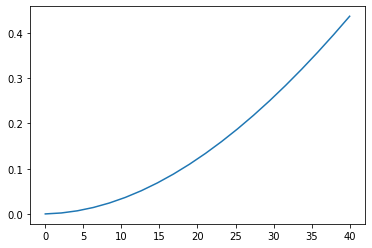

In [69]:
plt.plot(nbarfs,shifts2)

In [8]:
def RamseyErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [65]:
#pts = 15
#nbarfs = np.linspace(0, 100, pts)
Ncut = 401
#psi0 = psi(0.0, 1.0)
#Delta = 0.23 #*2.0*np.pi #hz
#Omega0 = 20.0*2.0*np.pi #hz
#nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = 5.0*np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05

shifts3 = np.zeros(pts)
tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 2.0

for ii in range(pts):
    print(nbarfs[ii])
    shifts3[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts3[ii])
    x0 = shifts3[ii] - guessTol
    x1 = shifts3[ii] + guessTol
    #print(x0,x1)

0.0
0.05533954285101383
2.1052631578947367
0.054595150849006166
4.2105263157894735
0.05387020487972807
6.315789473684211
0.053162789527483566
8.421052631578947
0.05247109779446414
10.526315789473683
0.051793427101286225
12.631578947368421
0.05112817476286371
14.736842105263158
0.05047383306956078
16.842105263157894
0.049828984102636566
18.94736842105263
0.04919229444423607
21.052631578947366
0.04856251008072057
23.157894736842103
0.047938452073555585
25.263157894736842
0.047319013801515084
27.36842105263158
0.04670316047449687
29.473684210526315
0.04608993112151865
31.57894736842105
0.045478442581485354
33.68421052631579
0.044867894504930346
35.78947368421053
0.044257574188594766
37.89473684210526
0.043646860195110625
40.0
0.043035224049275955


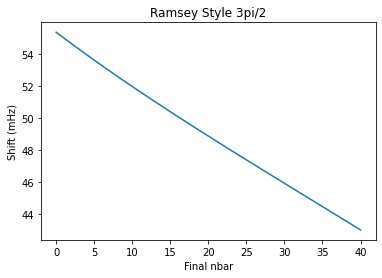

In [66]:
plt.plot(nbarfs,shifts3*1e3, label="HRS")
plt.title("Ramsey Style 3pi/2")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.show()
#plt.ylim([-1,1])

In [14]:
t2 = 5.0*np.pi/(2.0*Omega0)
shifts4 = np.zeros(pts)
x0 = -0.5
x1 = 0.5
guessTol = 1.0
for ii in range(pts):
    print(nbarfs[ii])
    shifts4[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts4[ii])
    x0 = shifts4[ii] - guessTol
    x1 = shifts4[ii] + guessTol
    #print(x0,x1)

0.0
0.055339542851014334
7.142857142857143
0.05288927483767282
14.285714285714286
0.05061320302030384
21.42857142857143
0.048450683021501816
28.571428571428573
0.04635239163098295
35.714285714285715
0.044277973034228126
42.85714285714286
0.04219386484524495
50.0
0.04007145118094295
57.142857142857146
0.03788555837869792
64.28571428571429


KeyboardInterrupt: 

In [19]:
for ii in range(9,pts):
    print(nbarfs[ii])
    shifts4[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts4[ii])
    x0 = shifts4[ii] - guessTol
    x1 = shifts4[ii] + guessTol

64.28571428571429
0.0356132509629028
71.42857142857143
0.03323287021856791
78.57142857142857
0.030723258282535335
85.71428571428572
0.0280631136741063
92.85714285714286
0.025230427505680202
100.0
0.022201954308010446


Text(0, 0.5, 'Shift (mHz)')

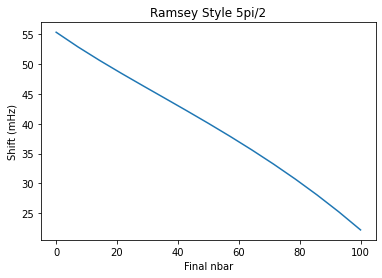

In [21]:
plt.plot(nbarfs,shifts4*1e3, label="Ramsey S")
plt.title("Ramsey Style 5pi/2")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")

In [9]:
def HRJumpThermErrSigFront(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(thermPulse(psi0, t1/3.0, Omega0, delPrime, eta, nbar0, Ncut), 2.0*t1/3.0, -Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [17]:
Ncut = 601
psi0 = psi(0.0, 1.0)
pts=20
nbarfs= np.linspace(0,40,pts)
Delta = -0.02 #*2.0*np.pi #hz
Omega0 = 20.0*2.0*np.pi #hz
nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = np.pi/(2.0*Omega0)
T = 200.0e-3
eta = 0.05
shifts5 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0

for ii in range(pts):
    print(nbarfs[ii])
    shifts5[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts5[ii])
    x0 = shifts5[ii] - guessTol
    x1 = shifts5[ii] + guessTol
    #print(x0,x1)

0.0
-0.0014732612875850983
2.1052631578947367
-0.0014712417515648291
4.2105263157894735
-0.0014692644622644835
6.315789473684211
-0.0014673284016108656
8.421052631578947
-0.0014654325751433169
10.526315789473683
-0.0014635760118668479
12.631578947368421
-0.0014617577639166393
14.736842105263158
-0.0014599769063145585
16.842105263157894
-0.0014582325366484775
18.94736842105263
-0.0014565237747159387
21.052631578947366
-0.0014548497622202756
23.157894736842103
-0.0014532096623175914
25.263157894736842
-0.001451602659241467
27.36842105263158
-0.001450027958029326
29.473684210526315
-0.0014484847840334331
31.57894736842105
-0.0014469723827410816
33.68421052631579
-0.0014454900197163692
35.78947368421053
-0.0014440369806982011
37.89473684210526
-0.0014426125719827797
40.0
-0.001441216121094161


In [18]:
np.savetxt("Ramseypi2.csv", shifts5, delimiter=',')

In [55]:
data

array([4.92336351e-07, 1.08715792e-04, 2.14628916e-04, 3.18351169e-04,
       4.19997457e-04, 5.19678156e-04, 6.17499151e-04, 7.13561899e-04,
       8.07963500e-04, 9.00796782e-04, 9.92150398e-04, 1.08210892e-03,
       1.17075296e-03, 1.25815926e-03, 1.34440079e-03, 1.42954683e-03,
       1.51366298e-03, 1.59681112e-03, 1.67904926e-03, 1.76043134e-03])

In [93]:
np.savetxt("FineDopplerAndStark.csv", shifts*nu0, delimiter=',')

In [71]:
np.savetxt("Ramsey5pi2.csv", shifts3, delimiter=',')

In [72]:
np.savetxt("MHRS2.csv", shifts2, delimiter=',')